Para hacer apply a un daskdataframe es necesario pasarle meta que es el tipo de datos que va a tener. https://stackoverflow.com/a/44437675

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import dask.dataframe as dd # en caso de tener muchos datos
import locale
import re
locale.setlocale(locale.LC_TIME, "es_ES") 

'es_ES'

In [2]:
os.listdir()

['.git', '.gitignore', '2022_emt_evolucion.ipynb', 'datos', 'images']

In [3]:
files = glob.glob("datos/*/*.csv")
# print(files)
# files = glob.glob("*/*Enero-Junio_*.csv")
files

['datos\\Coches_Cuadro_Oferta_Real_2019\\Coches_Cuadro_Oferta_Real_Enero-Junio_2019.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2019\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2019.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2020\\Coches_Cuadro_Oferta_Real_Enero-Junio_2020.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2020\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2020.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2021\\Coches_Cuadro_Oferta_Real_Enero-Junio_2021.csv',
 'datos\\Coches_Cuadro_Oferta_Real_2021\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2021.csv']

In [4]:
# Read column names from file
cols = list(pd.read_csv(files[0], sep=';',nrows=1))
cols = list(filter(lambda col: col.strip(), cols))


#Cargamos los datos y especificamos los tipos en las columnas, así como eliminar la última columna por ser vacia
dfs = [pd.read_csv(f, header=0, sep=";",encoding = "ISO-8859-1",dtype={'Elinea':'str'},usecols=cols) for f in files]
df = pd.concat(dfs,ignore_index=True)


# Elimnar el último dataframe del último fichero de la memoria
del dfs

In [5]:
df.FServicio = pd.to_datetime(df.FServicio, format='%d/%m/%Y')

tiempos = pd.DataFrame({'FServicio': pd.date_range('2019-01-01', '2021-12-31', freq='D')})
tiempos['fechaCorta'] = tiempos['FServicio'].dt.strftime('%B.%Y')
tiempos

,FServicio,fechaCorta
0,2019-01-01,enero.2019
1,2019-01-02,enero.2019
2,2019-01-03,enero.2019
3,2019-01-04,enero.2019
4,2019-01-05,enero.2019
...,...,...
1091,2021-12-27,diciembre.2021
1092,2021-12-28,diciembre.2021
1093,2021-12-29,diciembre.2021
1094,2021-12-30,diciembre.2021


In [6]:
df = df.join(tiempos.set_index('FServicio'),on='FServicio')

In [7]:
# cabeceras = df.loc[:,['CLinea','Elinea','Denominacion']].drop_duplicates().reset_index(drop=True)
# cabeceras[cabeceras['Elinea']!='SE']
# df.sort_values(by=['CLinea','FServicio','IDFranja'])
# df['year'] = df['FServicio'].dt.year
# df['month'] = df['FServicio'].dt.month

In [8]:
# Completamos con 0 las franjas horarias que esten a nulo.
df['Coches'] = df['Coches'].fillna(0)

# Añadimos si ese día era L-V o S-D
df['Diario'] = True
df.loc[df['FServicio'].dt.dayofweek > 4,'Diario'] = False

In [9]:
df['avg_coches'] = df.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')
# https://stackoverflow.com/questions/38869778/pandas-set-column-equal-to-grouped-sum-of-another-column?noredirect=1&lq=1


In [10]:
df[\
            (df['IDFranja']=='H07')\
            &(df['CLinea']==1)\
            &(df['FServicio'].dt.year==2019)\
            &(df['FServicio'].dt.month==1)\
        ]

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,enero.2019,True,5.580645
19,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-02,H07,070000 - 075959,6.0,enero.2019,True,5.580645
38,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-03,H07,070000 - 075959,6.0,enero.2019,True,5.580645
57,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-04,H07,070000 - 075959,6.0,enero.2019,True,5.580645
76,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-05,H07,070000 - 075959,3.0,enero.2019,False,5.580645
94,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-06,H07,070000 - 075959,3.0,enero.2019,False,5.580645
112,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-07,H07,070000 - 075959,3.0,enero.2019,True,5.580645
131,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-08,H07,070000 - 075959,7.0,enero.2019,True,5.580645
150,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-09,H07,070000 - 075959,7.0,enero.2019,True,5.580645
169,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-10,H07,070000 - 075959,7.0,enero.2019,True,5.580645


In [11]:
# De esta forma pierdo las columnas de 'Denominación' etc. 
# medias_buses = df.groupby(['CLinea','year','month','IDFranja'],as_index=False).mean() 

# En cambio eliminando los duplicados fijándonos por CLinea, FechaCorta e ID Franja mantenemos todas las columnas.
media_buses = df.drop_duplicates(['CLinea','fechaCorta','IDFranja','avg_coches'])

In [12]:
media_buses[(media_buses['IDFranja']=='H07')&(media_buses['CLinea']==25)]

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
79249,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H07,070000 - 075959,3.0,enero.2019,True,10.709677
79859,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-02-01,H07,070000 - 075959,14.0,febrero.2019,True,11.071429
80410,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-03-01,H07,070000 - 075959,14.0,marzo.2019,True,11.000000
81020,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-04-01,H07,070000 - 075959,15.0,abril.2019,True,10.933333
81606,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-05-01,H07,070000 - 075959,4.0,mayo.2019,True,10.838710
82213,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-06-01,H07,070000 - 075959,4.0,junio.2019,False,10.833333
720078,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-07-01,H07,070000 - 075959,12.0,julio.2019,True,8.516129
720690,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-08-01,H07,070000 - 075959,7.0,agosto.2019,True,6.483871
721298,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-09-01,H07,070000 - 075959,3.0,septiembre.2019,False,10.166667
721890,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-10-01,H07,070000 - 075959,15.0,octubre.2019,True,12.193548


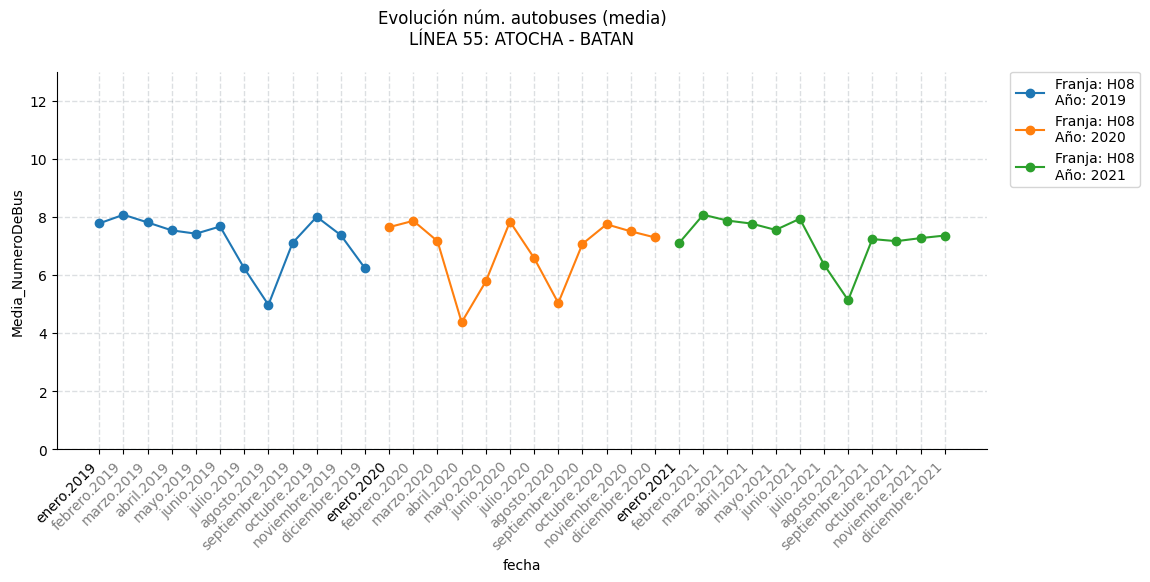

In [15]:
fig, axes = plt.subplots(figsize=(12, 5),dpi=100)
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

num_linea = 55
franja = 'H08'

# Filtro por linea y franja
data = media_buses[(media_buses['IDFranja']==franja)&(media_buses['CLinea']==num_linea)].reset_index(drop=True)
cartel_linea = str(data.loc[0,"Denominacion"])

# Visualizo los datos (avg_coches) y fechas
for fecha in data['FServicio'].dt.year.unique():
    # df.loc[df.index >= N, 'GDP'].plot(color='r', ax=ax)
    axes.plot(data.loc[data['FServicio'].dt.year == fecha,'fechaCorta'],data.loc[data['FServicio'].dt.year == fecha,'avg_coches'],'-o',label='Franja: '+ franja +'\nAño: '+str(fecha))


# Configuraciones visuales
axes.set_xticks(data['fechaCorta'])
axes.set_xticklabels(data['fechaCorta'], rotation = 45, ha="right",fontdict=dict({'color': 'grey'}))
axes.set_ylim([0,data['Coches'].max()+3])

xTicks = axes.get_xticklabels()
indices_enero = [i for i, item in enumerate(data.fechaCorta) if re.search('enero', item)]
for indeceEnero in indices_enero:
    xTicks[indeceEnero].set_color('black')
    # axes.vlines(x=indeceEnero,ymin=0,ymax=axes.get_yticks().max(),colors='black',linestyles='dashed',)

# Título y nombre ejes
axes.set_xlabel('fecha')
axes.set_ylabel('Media_NumeroDeBus')
axes.set_title(label=f'Evolución núm. autobuses (media)\nLÍNEA {num_linea}: {cartel_linea}',pad=20)
# axes.set(
#     xlabel='Mes',
#     ylabel='Media_NumeroDeBus',
#     title=f'Evolución núm. autobuses (media)\nLÍNEA {num_linea}: {cartel_linea}'
#     )
axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='both', alpha=0.15)
leg= axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)


plt.draw()

# FALTA POR HACER ESTO-> Poner una caja debajo de las leyedenas que muestren datos como máx y min
# p = leg.get_window_extent()
# print(p)
# axes.annotate('Annotation Text', (p.p0[0], p.p1[1]+10), (p.p0[0], p.p1[1]), 
#             xycoords='figure pixels', zorder=9)


# plt.legend(loc="lower right") # Esto puede deshabilitar quitando la línea
plt.savefig(fname=f'images/LÍNEA_{num_linea}_{franja}_{cartel_linea}.jpg',format='jpg', bbox_inches='tight')
plt.show()